# <center> MA234 期末project

12011327 刘乐奇

### 一、数据

数据主要包括2010年1月1日至2014年12月31日间北京pm2.5指数以及相关天气指数数据。在预处理中需要每7天抽一个数据作为验证集，其余作为测试集。

### 二、数据预处理及模型训练与验证

#### 1、数据预处理

In [32]:
# import the packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error
from chinese_calendar import is_workday # used to decide whether it is workday

读入数据集，用drop_duplicates函数将重复数据都删除（但是该数据集中并没有重复数据）。但是可以看到pm2.5列有43824-41757=2067个缺失值数据。

In [33]:
# read in data 
PRSA_df = pd.read_csv('./data/PRSA_data.csv')
PRSA_df.info()

# delete duplicate data
print(PRSA_df.shape[0] == PRSA_df.drop_duplicates().shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB
True


将 'cbwd' 列数据做独热码处理，并生成一些新特征。

In [34]:
# one-hot coding on cbwd
PRSA_df = PRSA_df.join(pd.get_dummies(PRSA_df.cbwd))

# date
PRSA_df['date'] = pd.to_datetime(PRSA_df[['year','month','day','hour']])

# time
def time_period(x):
    if x in range(6,12):
        return 1               # 'morning'
    elif x in range(12,18):
        return 2               # 'afternoon'
    elif x in range(18,24):
        return 3               # 'evening'
    elif x in range(0,6):
        return 4               # 'night'

PRSA_df['time_period'] = PRSA_df['hour'].apply(time_period)

# week
# 1 for weekday, 2 for weekend
PRSA_df['day_of_week'] = PRSA_df['date'].apply(lambda x: x.weekday()+1)
PRSA_df['week_time'] = ((PRSA_df['day_of_week'] == 6) | (PRSA_df['day_of_week'] == 7)) + 1

# holiday
# 1 for workday, 2 for holiday
PRSA_df['holiday'] = PRSA_df['date'].apply(lambda x: 1 if is_workday(x) else 2)

# season
def season_divide(x):
    if x in range(3,6):
        return 1               # 'Spring'
    elif x in range(6,9):
        return 2               # 'Summer'
    elif x in range(9,12):
        return 3               # 'Autumn'
    else:
        return 4               # 'Winter'

PRSA_df['season'] = PRSA_df['month'].apply(season_divide)

每7天抽一个数据作为验证集，其余作为训练集。在这里新建一列作为训练集和验证集的标志。

In [35]:
# denote is used to divide the train set and test set
first_date = pd.to_datetime('2010-01-07')
PRSA_df['denote'] = PRSA_df['date'].apply(lambda x: (pd.to_datetime(x)-first_date)/pd.Timedelta(days=1) % 7 != 0)

缺失值的处理：直接删除。

In [36]:
# delete the nan statistics
no_nan_df = PRSA_df.drop(index=PRSA_df[PRSA_df['pm2.5'].isnull()].index).reset_index(drop=True)

#### 2、pm2.5的分布和处理

In [37]:
from scipy.stats import norm
from scipy import stats

通过数据可视化直观地了解要预测的pm2.5的分布情况。很显然，要预测的pm2.5值的分布是右偏的，峰度4.7左右，与正态分布相距较远。

d:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.8023114189653855
Kurtosis: 4.768933321102571


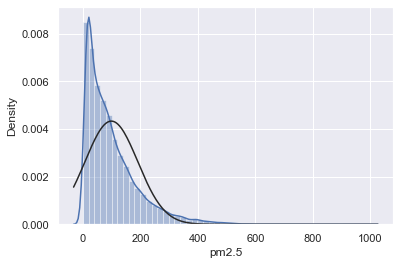

In [38]:
sns.distplot(no_nan_df['pm2.5'], fit=norm)
print("Skewness: {}".format(no_nan_df['pm2.5'].skew()))
print("Kurtosis: {}".format(no_nan_df['pm2.5'].kurt()))

通过probplot函数计算一个当前样本最可能的线性拟合，并用plt展示出来，可以看到线性拟合程度并不好。但是或许对pm2.5值做log对数处理后将会有较好的效果。

((array([-4.15033561, -3.94265485, -3.82935352, ...,  3.82935352,
          3.94265485,  4.15033561]),
  array([  0.,   0.,   1., ..., 972., 980., 994.])),
 (84.06218578546721, 98.61321455085373, 0.9131409965307454))

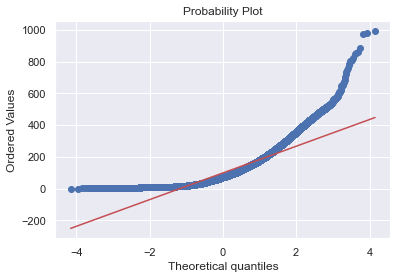

In [39]:
plt.figure()
stats.probplot(no_nan_df['pm2.5'], plot=plt)

由于log对数处理对0值会生成float infinity，故需要将pm2.5值为0的数据删除。可以看到，pm2.5为0的数据只有两条，删除影响不大。

In [40]:
no_nan_df[no_nan_df['pm2.5'] == 0]

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,NW,SE,cv,date,time_period,day_of_week,week_time,holiday,season,denote
22304,24035,2012,9,28,10,0.0,-5,20.0,1020.0,NW,...,1,0,0,2012-09-28 10:00:00,1,5,1,1,3,True
22309,24040,2012,9,28,15,0.0,-10,24.0,1017.0,NW,...,1,0,0,2012-09-28 15:00:00,2,5,1,1,3,True


In [41]:
no_nan_df = no_nan_df.drop(no_nan_df[no_nan_df['pm2.5'] == 0].index).reset_index(drop=True)
no_nan_df['pm2.5_log'] = np.log(no_nan_df['pm2.5'])

可以看到，对pm2.5值做log对数处理后分布好多了，基本上符合了正态分布。而且也有一个比较好的线性拟合。

d:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.802321832311242
Kurtosis: 4.768982375083562


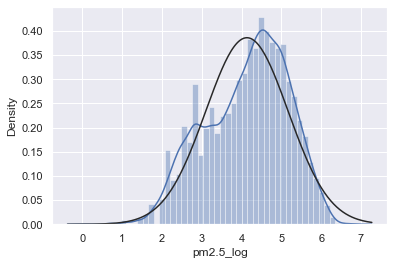

In [42]:
sns.distplot(no_nan_df['pm2.5_log'], fit=norm)
print("Skewness: {}".format(no_nan_df['pm2.5'].skew()))
print("Kurtosis: {}".format(no_nan_df['pm2.5'].kurt()))

((array([-4.15032465, -3.94264337, -3.82934173, ...,  3.82934173,
          3.94264337,  4.15032465]),
  array([0.        , 0.        , 0.        , ..., 6.8793558 , 6.88755257,
         6.90173721])),
 (1.023130250302235, 4.135784925684185, 0.9897679002754348))

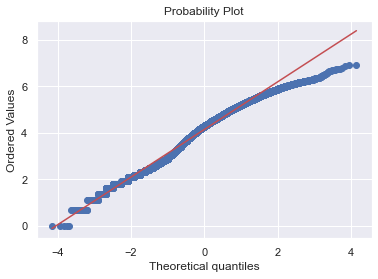

In [43]:
plt.figure()
stats.probplot(no_nan_df['pm2.5_log'], plot=plt)

#### 3、一些特征和pm2.5之间的相关性

Dew point 露点 ('DEWP')。也即空气中水气含量达到饱和的气温。\
Temperature 温度 ('TEMP')。也即观察时对应的温度。\
Pressure 压强 ('PRES')。也即观察时对应的压强。\
Cumulated wind speed 累积风速 ('Iws')。也即观察时对应的累积风速。\
Cumulated hours of snow 累积降雪 ('Is')。也即观察时对应的累积降雪。\
Cumulated hours of rain 累积降雨 ('Ir')。也即观察时对应的累积降雨。

单从散点图来看，风速('lws')、降雪('ls')和降雨('lr')（第二行的三幅图分别从左至右）对pm2.5的影响较大。而其他特征与pm2.5的相关性较低。

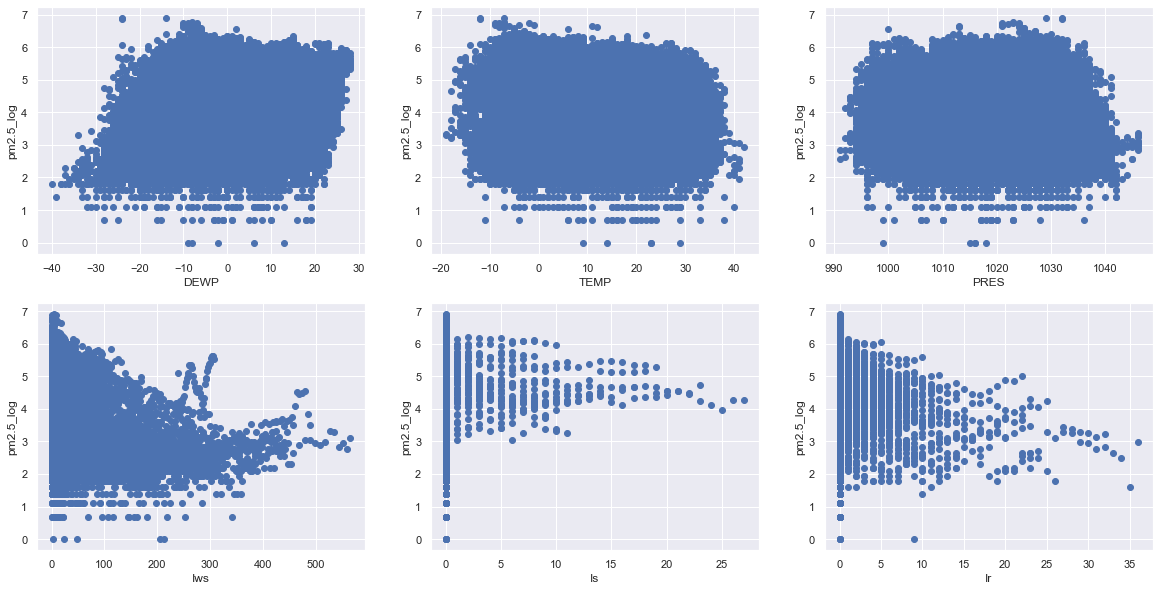

In [44]:
features = ['DEWP','TEMP','PRES','Iws','Is','Ir']
plt.figure(figsize=(20,10))
n = 1
for feature in features:
    data = pd.concat([no_nan_df['pm2.5_log'], no_nan_df[feature]], axis=1)
    plt.subplot(2,3,n)
    plt.scatter(x=data[feature], y=data['pm2.5_log'])
    plt.xlabel(feature)
    plt.ylabel('pm2.5_log')
    n += 1

使用箱线图看看风向('cbwd')与pm2.5的关系。可以看出，在不同风向下，pm2.5的分布都比较稳定，但是吹西北风('NW')时，pm2.5的值都大体较小；而静风('cv')时，pm2.5的值都比较大。

(-0.5, 3.5, 0.0, 10.0)

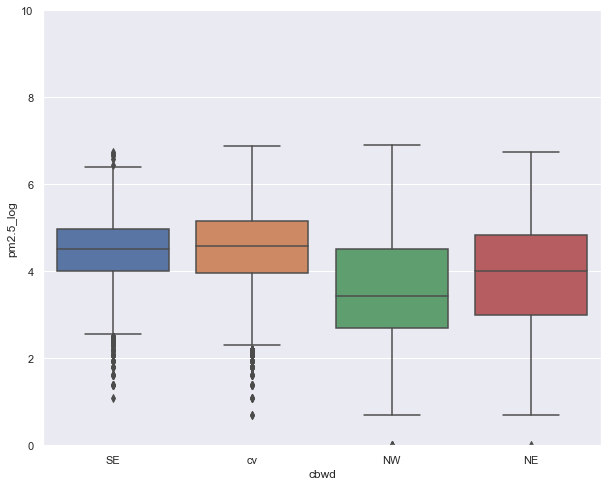

In [45]:
cbwd = pd.concat([no_nan_df['pm2.5_log'], no_nan_df['cbwd']], axis=1)
fig, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='cbwd', y='pm2.5_log', data=cbwd)
fig.axis(ymin=0, ymax=10)

换用相关性矩阵看特征的相关性

<AxesSubplot:>

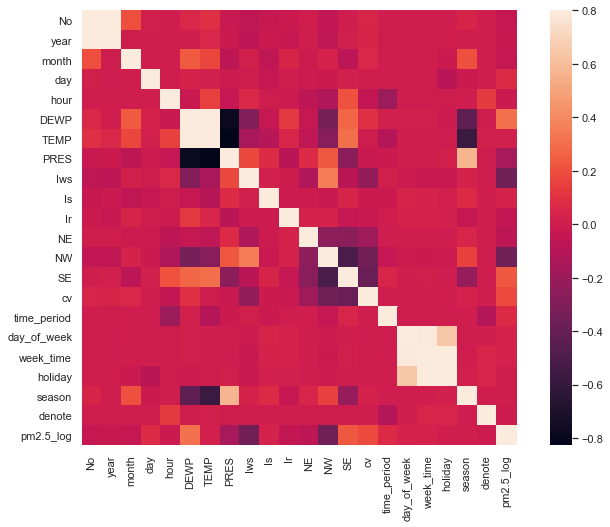

In [46]:
corr_mat = no_nan_df.loc[:,no_nan_df.columns != 'pm2.5'].corr()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_mat, vmax=0.8, square=True)

由于特征太多，只看与pm2.5正相关和负相关各最强的5个特征。可以看出，风向对pm2.5的影响是很大的。除此之外，露点和累积风速也对pm2.5有较大影响，在高露点时有较高的pm2.5，而累积风速越大，pm2.5越低。

<AxesSubplot:>

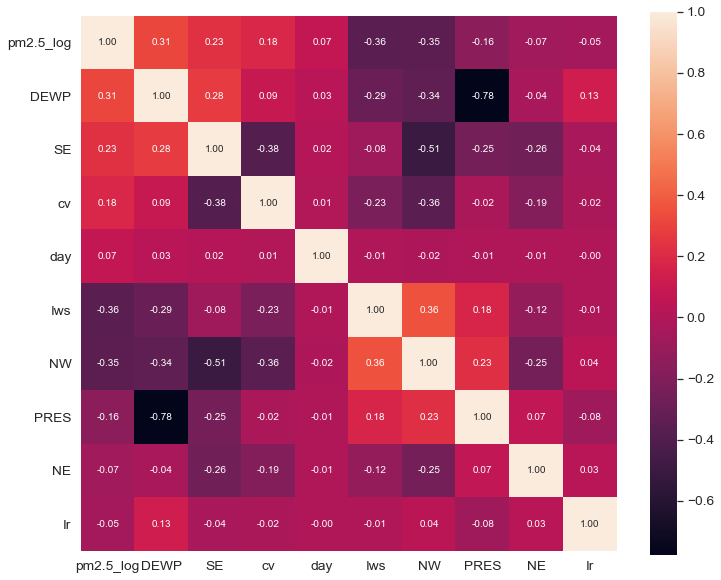

In [47]:
k = 5 # number of correlated features in heatmap
cols_large = corr_mat.nlargest(k, 'pm2.5_log')['pm2.5_log'].index 
cols_small = corr_mat.nsmallest(k, 'pm2.5_log')['pm2.5_log'].index 
cols = cols_large.append(cols_small)

cc = np.corrcoef(no_nan_df[cols].values.T)
sns.set(rc={"figure.figsize":(12,10)}) 
sns.set(font_scale=1.25)
sns.heatmap(cc, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)

除开风向，可以看出一天的不同时段(time_period)（上午、下午、晚上、深夜）对pm2.5值也有一定的影响。

<AxesSubplot:>

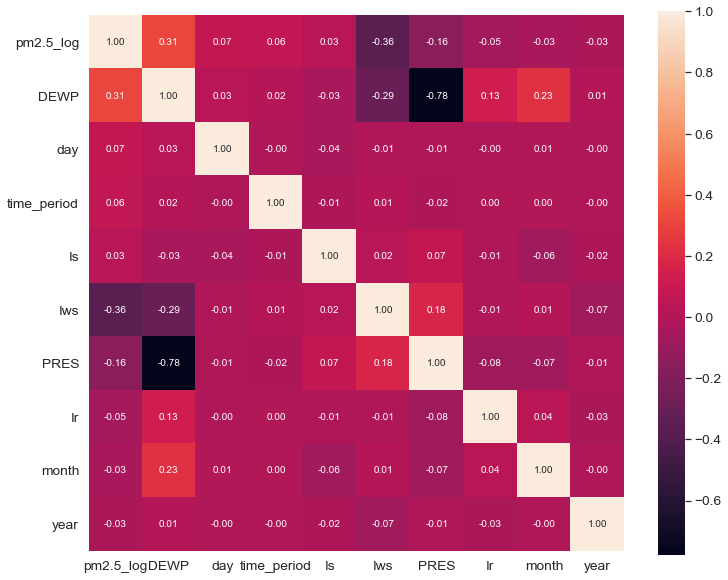

In [48]:
var = ['year','month','day','hour','pm2.5_log','DEWP','TEMP','PRES','Iws','Is','Ir','time_period','week_time','holiday','season']
corr_mat = no_nan_df[var].corr()

k = 5 # number of correlated features in heatmap
cols_large = corr_mat.nlargest(k, 'pm2.5_log')['pm2.5_log'].index 
cols_small = corr_mat.nsmallest(k, 'pm2.5_log')['pm2.5_log'].index 
cols = cols_large.append(cols_small)

cc = np.corrcoef(no_nan_df[cols].values.T)
sns.set(rc={"figure.figsize":(12,10)}) 
sns.set(font_scale=1.25)
sns.heatmap(cc, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)

#### 4、模型训练与验证

提取训练集和测试集。取 X = ['DEWP','TEMP','PRES','Iws','Is','Ir','NE','NW','SE','cv']

In [49]:
# get the train set and test set
train_df = no_nan_df[no_nan_df['denote'] == True]
test_df = no_nan_df[no_nan_df['denote'] == False]

x_var = ['DEWP','TEMP','PRES','Iws','Is','Ir','NE','NW','SE','cv']
X_train, X_test = train_df[x_var], test_df[x_var]
y_train, y_test = train_df['pm2.5_log'], test_df['pm2.5_log']

三种简单的线性回归模型。

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV

交叉验证找最优参数

In [61]:
lasso_cv = LassoCV(alphas=np.logspace(-5,2,100), cv=10)
lasso_cv.fit(X_train,y_train)
print('lasso alpha: {}'.format(lasso_cv.alpha_))

ridge_cv = RidgeCV(alphas=np.logspace(-5,2,100), cv=10)
ridge_cv.fit(X_train,y_train)
print('ridge alpha: {}'.format(ridge_cv.alpha_))

lasso alpha: 1e-05
ridge alpha: 100.0


In [62]:
# linear regression 线性回归
lr_nan = LinearRegression().fit(X_train, y_train)
y_pred_lr_nan = lr_nan.predict(X_test)
r2_lr_nan = lr_nan.score(X_test, y_test)
mse_lr_nan = mean_squared_error(y_true=y_test, y_pred=y_pred_lr_nan)

# ridge regression 岭回归
rr = Ridge(alpha=100).fit(X_train, y_train)
y_pred_rr = rr.predict(X_test)
r2_rr = rr.score(X_test, y_test)
mse_rr = mean_squared_error(y_true=y_test, y_pred=y_pred_rr)

# lasso regression
las = Lasso(alpha=1e-5).fit(X_train, y_train)
y_pred_las = las.predict(X_test)
r2_las = las.score(X_test, y_test)
mse_las = mean_squared_error(y_true=y_test, y_pred=y_pred_las)

打印出三种模型的各种分数。可以看出，三者的效果差不太多，而岭回归的效果比较好。

In [63]:
print('mean squre error:')
print('linear regression: {}'.format(mse_lr_nan))
print('ridge regression: {}'.format(mse_rr))
print('lasso regression: {}'.format(mse_las))

print('R^2 score:')
print('linear regression: {}'.format(r2_lr_nan))
print('ridge regression: {}'.format(r2_rr))
print('lasso regression: {}'.format(r2_las))

mean squre error:
linear regression: 0.6894037300941444
ridge regression: 0.6887433030527041
lasso regression: 0.6893933654417306
R^2 score:
linear regression: 0.3658681236394825
ridge regression: 0.36647560198737383
lasso regression: 0.3658776573222813


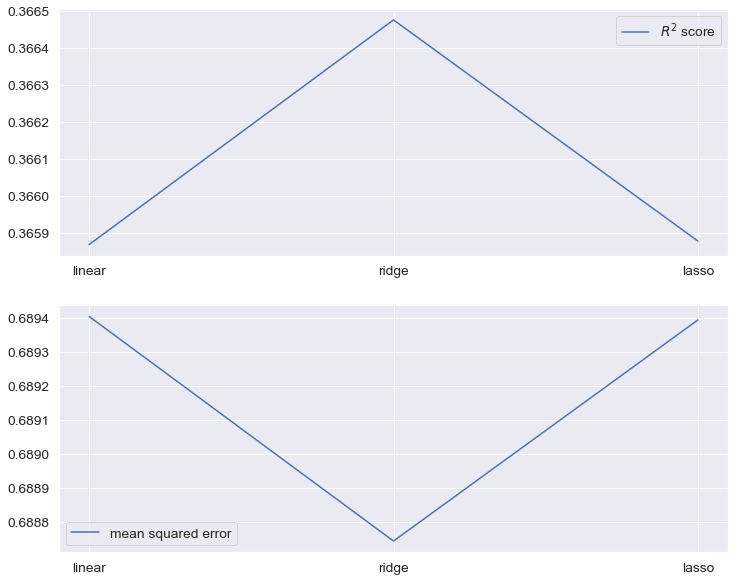

In [127]:
# plot to compare
fig, ax = plt.subplots(2)
ax[0].plot(['linear','ridge','lasso'], [r2_lr_nan, r2_rr, r2_las], label='$R^2$ score')
ax[0].legend(loc='best')
ax[1].plot(['linear','ridge','lasso'], [mse_lr_nan, mse_rr, mse_las], label='mean squared error')
ax[1].legend(loc='best')

PCA降维处理，看看能否使得MSE下降。但很可惜效果更差了。

In [54]:
from sklearn.decomposition import PCA

In [55]:
var = ['DEWP','TEMP','PRES','Iws','Is','Ir','NE','NW','SE','cv']
pca = PCA()
pca_df = pca.fit_transform(no_nan_df[var])

# get the train set and test set
pca_X_train = pca_df[no_nan_df['denote'] == True]
pca_X_test = pca_df[no_nan_df['denote'] == False]
pca_y_train = no_nan_df.loc[no_nan_df['denote'] == True, 'pm2.5_log']
pca_y_test = no_nan_df.loc[no_nan_df['denote'] == False, 'pm2.5_log']

In [81]:
pca_ridge = LinearRegression().fit(pca_X_train, pca_y_train)
pca_y_pred = pca_ridge.predict(pca_X_test)

print('mean squre error: {}'.format(mean_squared_error(y_true=pca_y_test, y_pred=pca_y_pred)))
print('R^2 score: {}'.format(pca_ridge.score(X_test, y_test)))

mean squre error: 0.6894037300941458
R^2 score: -2945.8873066101482


d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


使用支持向量机和决策树来做回归分析，以及用集成模型的Adaboost和RandomForest

In [66]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [68]:
# SVM 支持向量机
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
r2_svr = svr.score(X_test, y_test)
mse_svr = mean_squared_error(y_true=y_test, y_pred=y_pred_svr)

# Decision Tree 决策树
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)
r2_dtr = dtr.score(X_test, y_test)
mse_dtr = mean_squared_error(y_true=y_test, y_pred=y_pred_dtr)

# Adaboost
AdaBoost = AdaBoostRegressor(n_estimators=100)
AdaBoost.fit(X_train, y_train)
y_pred_ada = AdaBoost.predict(X_test)
r2_AdaBoost = AdaBoost.score(X_test, y_test)
mse_AdaBoost = mean_squared_error(y_true=y_test, y_pred=y_pred_ada)

# Random Forest 随机森林
RandomForest = RandomForestRegressor(n_estimators=20)
RandomForest.fit(X_train,y_train)
y_pred_for = AdaBoost.predict(X_test)
r2_RandomForest = RandomForest.score(X_test,y_test)
mse_RandomForest = mean_squared_error(y_true=y_test, y_pred=y_pred_for)

打印出四种模型的各种分数。可以看出，决策树的效果并不好，支持向量机和AdaBoost效果接近，在这四种之中Random Forest效果最优。但总的来说没有简单的线性模型好。

In [70]:
print('mean squre error:')
print('SVM: {}'.format(mse_svr))
print('Decision Tree: {}'.format(mse_dtr))
print('AdaBoost: {}'.format(mse_AdaBoost))
print('RandomForest: {}'.format(mse_RandomForest))

print('R^2 score:')
print('SVM: {}'.format(r2_svr))
print('Decision Tree: {}'.format(r2_dtr))
print('AdaBoost: {}'.format(r2_AdaBoost))
print('RandomForest: {}'.format(r2_RandomForest))

mean squre error:
SVM: 0.7232288229374053
Decision Tree: 0.8216268403624307
AdaBoost: 0.7045091117853487
RandomForest: 0.7045091117853487
R^2 score:
SVM: 0.33475490411884445
Decision Tree: 0.2442457921194573
AdaBoost: 0.35197379203544965
RandomForest: 0.5827916931960377


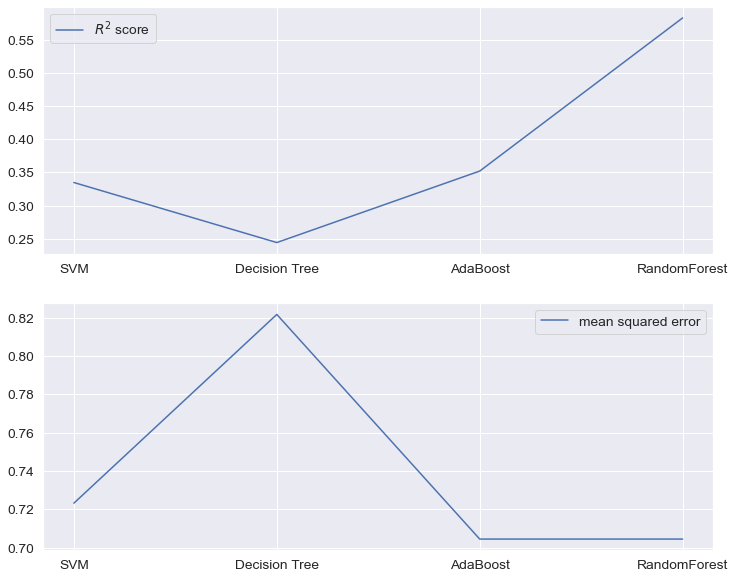

In [125]:
# plot to compare
fig, ax = plt.subplots(2)
ax[0].plot(['SVM','Decision Tree','AdaBoost','RandomForest'], [r2_svr, r2_dtr, r2_AdaBoost, r2_RandomForest], label='$R^2$ score')
ax[0].legend(loc='best')
ax[1].plot(['SVM','Decision Tree','AdaBoost','RandomForest'], [mse_svr, mse_dtr, mse_AdaBoost, mse_RandomForest], label='mean squared error')
ax[1].legend(loc='best')

用mlxtend包实现Stacking集成学习方法。

目前，很多大型的数据挖掘比赛，排名靠前的基本上都是集成机器学习模型或者深度神经网络。将训练好的所有基模型对整个训练集进行预测，第j个基模型对第i个训练样本的预测值将作为新的训练集中第i个样本的第j个特征值，最后基于新的训练集进行训练。同理，预测的过程也要先经过所有基模型的预测形成新的测试集，最后再对测试集进行预测。

由于Bagging和Boosting可以直接调用而Stacking需要自己设计，sklearn只实现了一些比较主流的集成学习方法（如RandomForest、AdaBoost等）。但是，mlxtend完美兼容sklearn，可以使用sklearn的模型进行组合生成新模型，而且它同时集成了Stacking分类和回归模型以及它们的交叉验证的版本。

In [72]:
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

In [76]:
# base model initialization
lr = LinearRegression()
svr_lin = SVR(kernel='linear', gamma='auto')
svr_rbf = SVR(kernel='rbf', gamma='auto')
ridge = Ridge(random_state=2022)
lasso = Lasso(random_state=2022)
models = [lr, svr_lin, svr_rbf, ridge, lasso]

# K-folder
K = 5

print('Base model')
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    cv_score = cross_val_score(model, X_train, y_train, cv=K)
    print("mean squre error: {}".format(mse))
    print(cv_score.mean(), '+/-', cv_score.std())
# Stacking Regressor
sclf = StackingRegressor(regressors=models, meta_regressor=ridge)
# Stacking CV Regressor
sclfcv = StackingCVRegressor(regressors=models, meta_regressor=ridge)

Base model
mean squre error: 0.6894037300941444
0.404596405089163 +/- 0.018792113328821705
mean squre error: 8234.883352384726
-5360.375784641142 +/- 692.103600498779
mean squre error: 0.5841041836743326
0.32160882491859644 +/- 0.022222715910088106
mean squre error: 0.689396941840624
0.40459668344094035 +/- 0.01879402481880172
mean squre error: 0.8039303087169065
0.251112722423973 +/- 0.026171040150892756


In [78]:
# regressor training
sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)

sclfcv.fit(X_train, y_train)
y_pred_cv = sclfcv.predict(X_test)

print('Stacking model')
print('mean squre error: {}'.format(mean_squared_error(y_test, y_pred)))
print('R^2 score: {}'.format(sclf.score(X_test, y_test)))

print('Stacking CV model')
print('mean squre error: {}'.format(mean_squared_error(y_test, y_pred_cv)))
print('R^2 score: {}'.format(sclfcv.score(X_test, y_test)))
# cv_sc = cross_val_score(sclfcv, X_train, y_train, cv=K)
# print(cv_sc.mean(), '+/-', cv_sc.std())

d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without 

Stacking model
mean squre error: 0.5961812963785035


d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


R^2 score: 0.45161659616793914
Stacking CV model
mean squre error: 0.5516733037619627


d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


R^2 score: 0.49255623086807765


d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


将预测值与验证值在图像中可视化比较，散点是预测值，曲线是验证值。可以看出，预测值还是比较符合验证值的，但是若对精度要求更高的话，效果仍然不太理想。

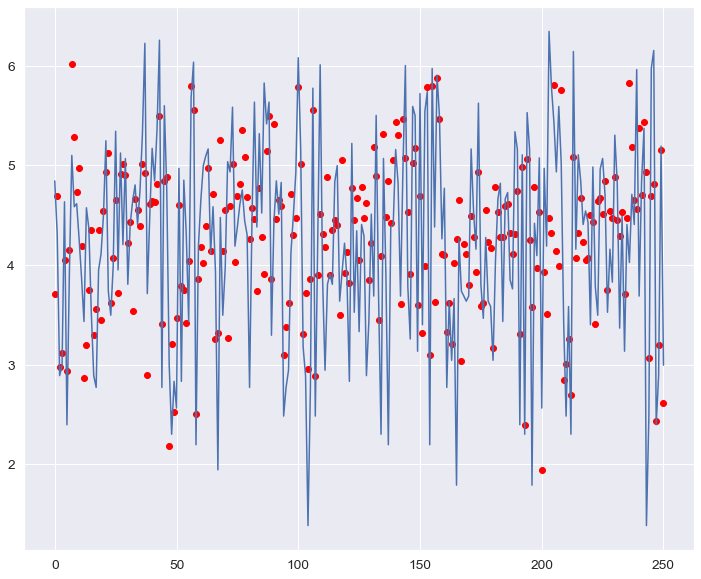

In [82]:
plt.scatter(np.arange(len(y_pred)), y_pred, c='red')
plt.plot(np.arange(len(y_test)), y_test)
plt.show()

使用GridSearchCV对上面的Stacking模型网格搜索调参。由于数据集太大，耗时太久（跑了244min都未出结果），因此不用。

In [37]:
# params = {
#     'lasso__alpha': [0.1, 1.0, 10.0],
#     'ridge__alpha': [0.1, 1.0, 10.0]
#     }
# grid = GridSearchCV(estimator=sclf, param_grid=params, cv=5, refit=True)
# grid.fit(X_train, y_train)
# print(grid.best_params_, grid.best_score_)

#### 4、其他特征对pm2.5的影响分析

除了以上涉及的特征，还有一些时间特征对pm2.5值可能有影响，下面对这些特征进行分析。

time_period 一天的不同时段（上午、下午、晚上、深夜）。\
week_time 平日和周末。\
holiday 工作日和节假日。\
season 四季。\
year 2010-2014的四个不同年份。

首先用相关性矩阵看这些时间特征与pm2.5值的相关性。但是结果表示这些时间特征与pm2.5的相关性都比较低。

<AxesSubplot:>

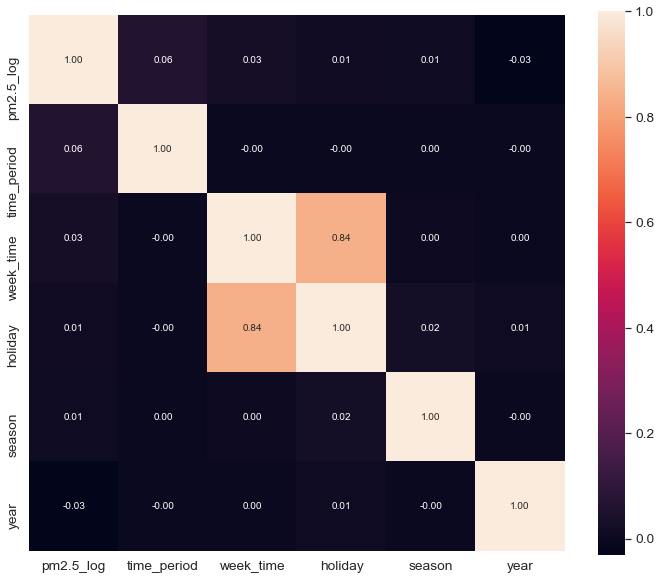

In [83]:
var = ['time_period','week_time','holiday','season','year','pm2.5_log']
corr_mat = no_nan_df[var].corr()

k = 6 # number of correlated features in heatmap
cols = corr_mat.nlargest(k, 'pm2.5_log')['pm2.5_log'].index

cc = np.corrcoef(no_nan_df[cols].values.T)
sns.set(rc={"figure.figsize":(12,10)}) 
sns.set(font_scale=1.25)
sns.heatmap(cc, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)

使用箱线图看看在各个时间特征中pm2.5的分布。

第一幅time_period和pm2.5_log的关系表明，在下午（hour=12-18）时pm2.5的中位数和下分位点都比较低，而在深夜（hour=0-6）时pm2.5的中位数和上分位点都比较高。

从第二幅和第三幅图看，在周末和假日（在各自的图中都是2）时pm2.5的值整体都有所上移。但是由于有调休的缘故，周末有时会要上班而平日可能会放假，所以第二幅图得出的平日和周末对pm2.5的影响可能并无太多意义。而第二幅图中严格分开了工作日和节假日，可以比较明显地看到在节假日中pm2.5值整体都高于在工作日中的。造成这种情况的原因很可能是节假日时人们较多出游，而如今城市中私家车比较普遍，更多的出行车辆造成了更高的pm2.5值。

Text(0.5, 0, 'week_holiday')

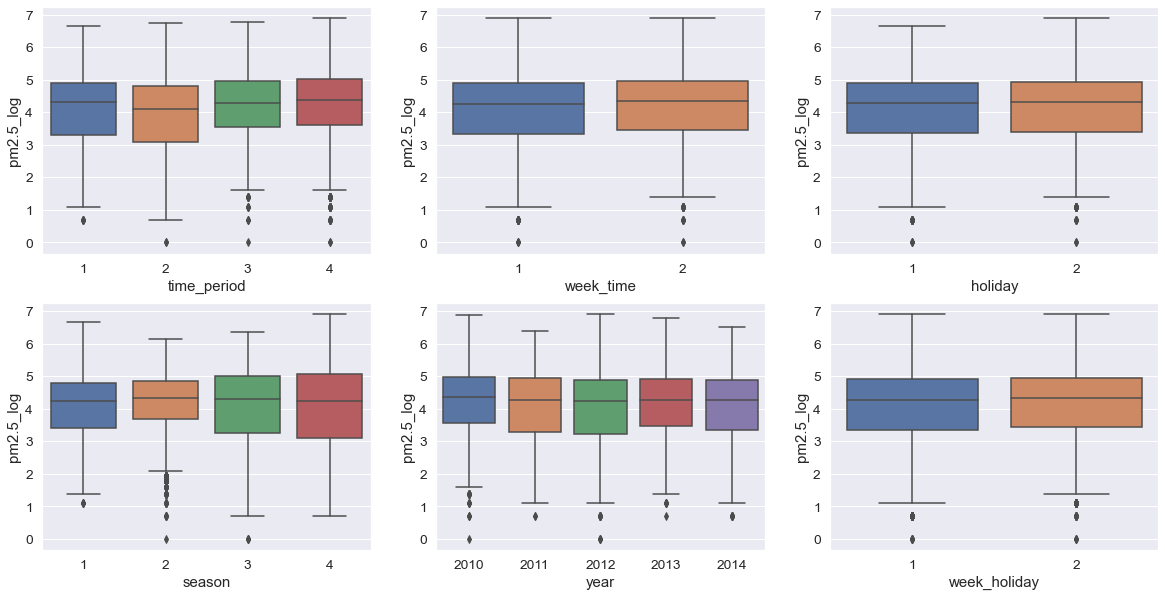

In [84]:
features = ['time_period','week_time','holiday','season','year']
plt.figure(figsize=(20,10))
n = 1
for feature in features:
    data = pd.concat([no_nan_df['pm2.5_log'], no_nan_df[feature]], axis=1)
    plt.subplot(2,3,n)
    sns.boxplot(x=data[feature], y=data['pm2.5_log'])
    plt.xlabel(feature)
    plt.ylabel('pm2.5_log')
    n += 1

week_holiday = pd.concat([pd.concat([no_nan_df['pm2.5_log'], no_nan_df['pm2.5_log']]), pd.concat([no_nan_df['week_time'],no_nan_df['holiday']])], axis=1)
plt.subplot(2,3,6)
sns.boxplot(x=week_holiday.iloc[:,1], y=week_holiday.iloc[:,0])
plt.xlabel('week_holiday')

提取训练集和测试集。取 X = ['time_period','week_time','holiday','season','year']

可以看出，预测的效果非常不好

In [85]:
# get the train set and test set
train_df = no_nan_df[no_nan_df['denote'] == True]
test_df = no_nan_df[no_nan_df['denote'] == False]

x_var = ['time_period','week_time','holiday','season','year']
X_train, X_test = train_df[x_var], test_df[x_var]
y_train, y_test = train_df['pm2.5_log'], test_df['pm2.5_log']

R^2 score: -0.0021491253847045755
mean square error: 1.0894978961095731
R^2 score: 0.01710509913317404
mean square error: 1.0685654454671627
R^2 score: -0.0492891728221434
mean square error: 1.1407467384272065


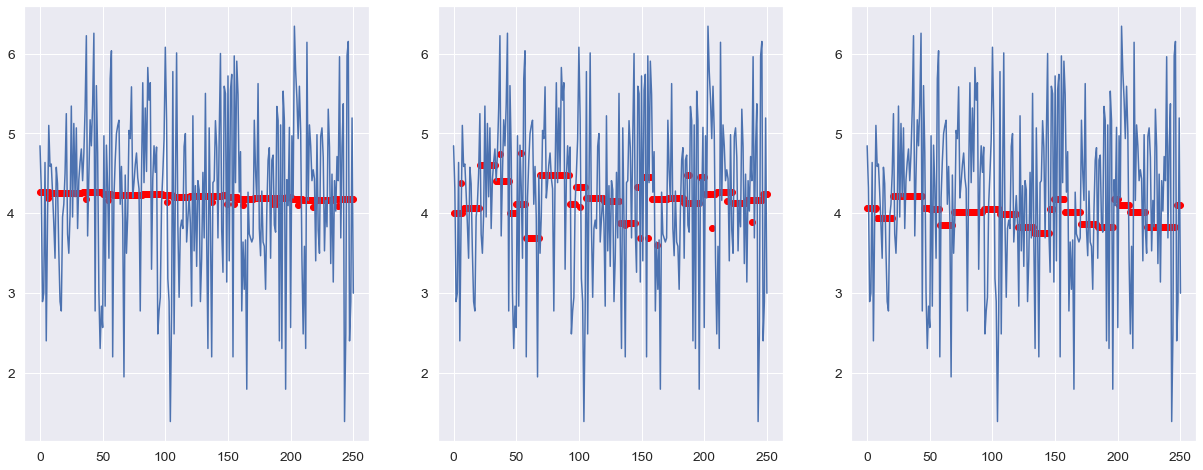

In [86]:
rr = Ridge().fit(X_train, y_train)
rf = RandomForestRegressor().fit(X_train, y_train)
ada = AdaBoostRegressor().fit(X_train, y_train)
models = [rr, rf, ada]

plt.figure(figsize=(21,8))
n = 1
for model in models:
    y_pred = model.predict(X_test)
    print('R^2 score: {}'.format(model.score(X_test, y_test)))
    print('mean square error: {}'.format(mean_squared_error(y_true=y_test, y_pred=y_pred)))
    plt.subplot(1,3,n)
    plt.scatter(np.arange(len(y_pred)), y_pred, c='red')
    plt.plot(np.arange(len(y_test)), y_test)
    n += 1

由点图可以看出，2012年的pm2.5的平均值是比较低的。

d:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year', ylabel='pm2.5'>

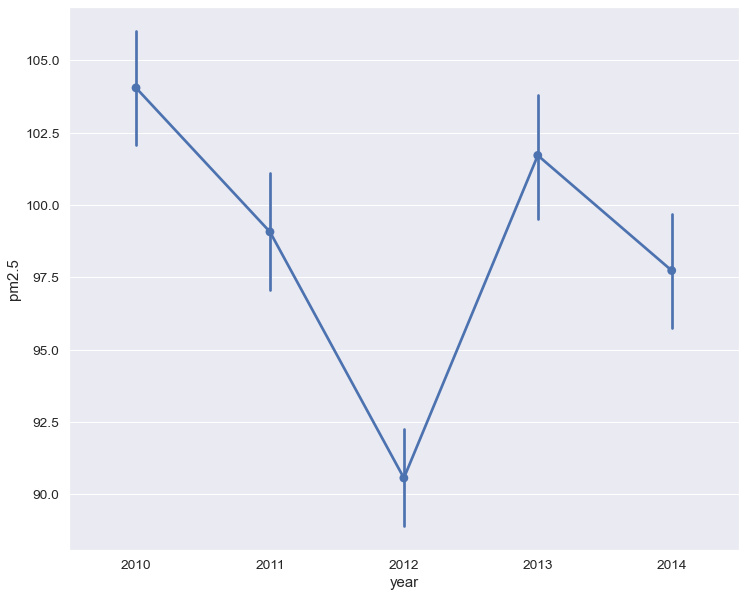

In [87]:
sns.pointplot(no_nan_df['year'], no_nan_df['pm2.5'])

在一天24小时中，大约在中午的时候pm2.5比较低，而pm2.5的均值在35到150之间，分级为mid。

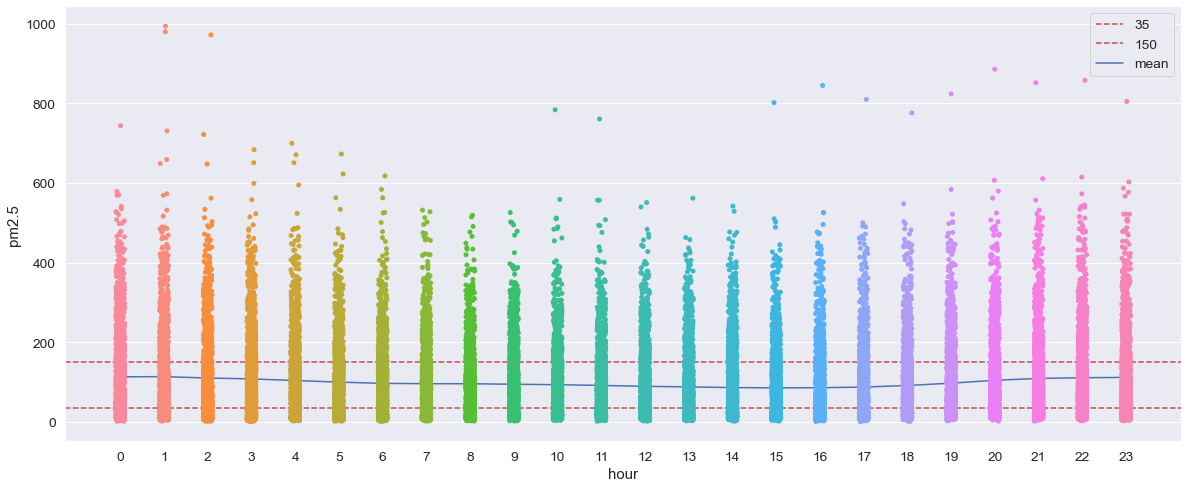

In [100]:
plt.figure(figsize=(20,8))
sns.stripplot(x='hour',y='pm2.5',data=no_nan_df)

plt.axhline(35, color='r', linestyle='--', label='35')
plt.axhline(150, color='r', linestyle='--', label='150')

pm_mean = no_nan_df.groupby(['hour'])['pm2.5'].mean()
plt.plot(pm_mean,label='mean')

plt.legend(loc='best')

### 三、不同的缺失值填充方法的比较

*为了简化操作，一下的比较都使用LinearRegression()训练并预测*

与前面的分析相同，三种方法都仍然对pm2.5做log对数处理。

#### 1、使用均值填充缺失值

((array([-4.16138035, -3.954223  , -3.84122771, ...,  3.84122771,
          3.954223  ,  4.16138035]),
  array([  0.,   0.,   1., ..., 972., 980., 994.])),
 (82.13617197449918, 98.61321455085373, 0.9140391896848946))

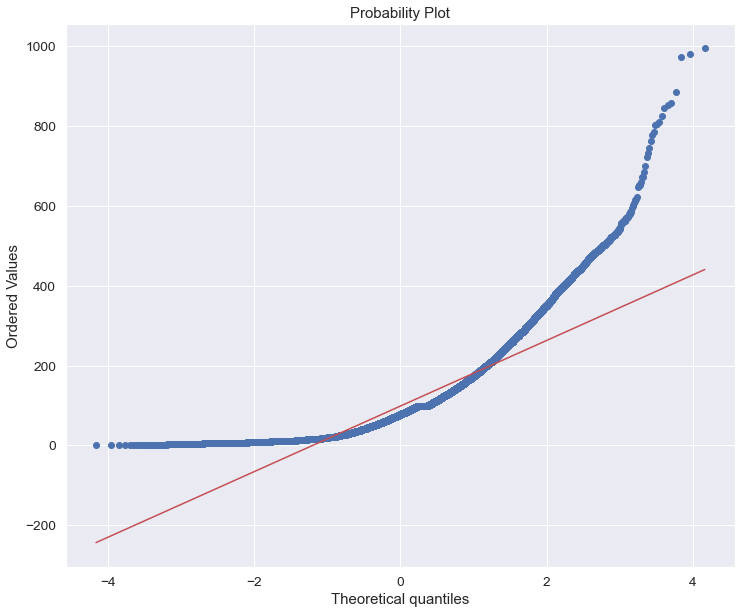

In [101]:
mean_fill_df = PRSA_df
mean_fill_df['pm2.5'] = mean_fill_df['pm2.5'].fillna(mean_fill_df['pm2.5'].mean())

plt.figure()
stats.probplot(mean_fill_df['pm2.5'], plot=plt)

In [102]:
mean_fill_df[mean_fill_df['pm2.5'] == 0]

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,NW,SE,cv,date,time_period,day_of_week,week_time,holiday,season,denote
24034,24035,2012,9,28,10,0.0,-5,20.0,1020.0,NW,...,1,0,0,2012-09-28 10:00:00,1,5,1,1,3,True
24039,24040,2012,9,28,15,0.0,-10,24.0,1017.0,NW,...,1,0,0,2012-09-28 15:00:00,2,5,1,1,3,True


((array([-4.16136993, -3.95421209, -3.84121651, ...,  3.84121651,
          3.95421209,  4.16136993]),
  array([0.        , 0.        , 0.        , ..., 6.8793558 , 6.88755257,
         6.90173721])),
 (1.0016016272607524, 4.157266233266752, 0.9881246526764511))

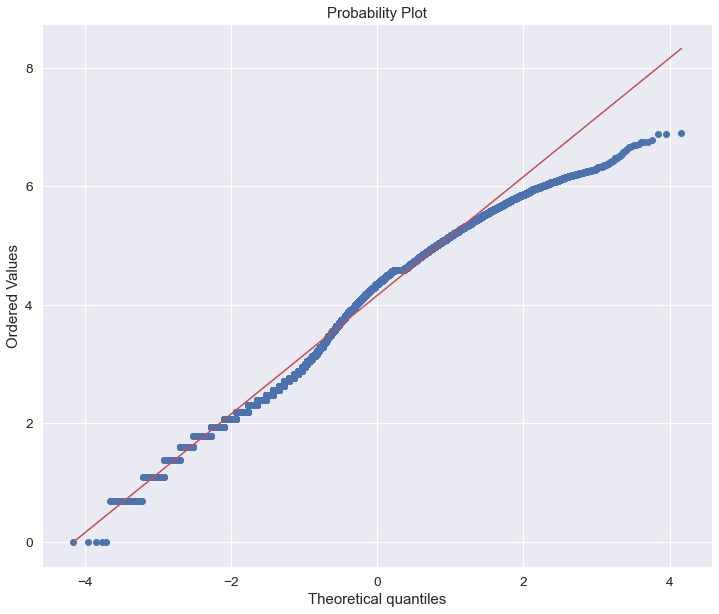

In [103]:
mean_fill_df = mean_fill_df.drop(mean_fill_df[mean_fill_df['pm2.5'] == 0].index).reset_index(drop=True)
mean_fill_df['pm2.5_log'] = np.log(mean_fill_df['pm2.5'])
plt.figure()
stats.probplot(mean_fill_df['pm2.5_log'], plot=plt)

In [104]:
# get the train set and test set
mean_train_df = mean_fill_df[mean_fill_df['denote'] == True]
mean_test_df = mean_fill_df[mean_fill_df['denote'] == False]

x_var = ['DEWP','TEMP','PRES','Iws','Is','Ir','NE','NW','SE','cv']
X_train, X_test = mean_train_df[x_var], mean_test_df[x_var]
y_train, y_test = mean_train_df['pm2.5_log'], mean_test_df['pm2.5_log']

In [105]:
lr_mean = LinearRegression().fit(X_train, y_train)
y_pred_lr_mean = lr_mean.predict(X_test)
r2_lr_mean = lr_mean.score(X_test, y_test)
mse_lr_mean = mean_squared_error(y_true=y_test, y_pred=y_pred_lr_mean)

#### 2、使用插值填充缺失值

((array([-4.16138035, -3.954223  , -3.84122771, ...,  3.84122771,
          3.954223  ,  4.16138035]),
  array([  0.,   0.,   1., ..., 972., 980., 994.])),
 (82.13617197449918, 98.61321455085373, 0.9140391896848946))

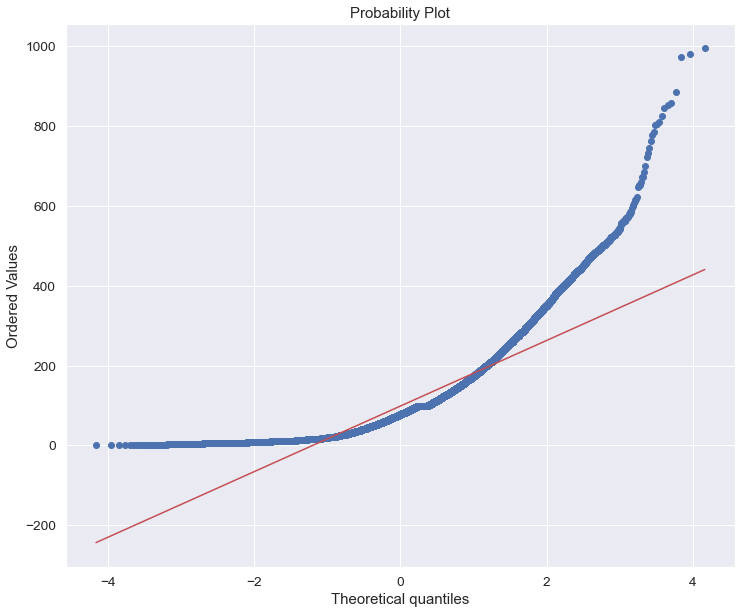

In [106]:
interp_fill_df = PRSA_df
interp_fill_df['pm2.5'] = interp_fill_df['pm2.5'].interpolate()

plt.figure()
stats.probplot(interp_fill_df['pm2.5'], plot=plt)

In [107]:
interp_fill_df[interp_fill_df['pm2.5'] == 0]

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,NW,SE,cv,date,time_period,day_of_week,week_time,holiday,season,denote
24034,24035,2012,9,28,10,0.0,-5,20.0,1020.0,NW,...,1,0,0,2012-09-28 10:00:00,1,5,1,1,3,True
24039,24040,2012,9,28,15,0.0,-10,24.0,1017.0,NW,...,1,0,0,2012-09-28 15:00:00,2,5,1,1,3,True


((array([-4.16136993, -3.95421209, -3.84121651, ...,  3.84121651,
          3.95421209,  4.16136993]),
  array([0.        , 0.        , 0.        , ..., 6.8793558 , 6.88755257,
         6.90173721])),
 (1.0016016272607524, 4.157266233266752, 0.9881246526764511))

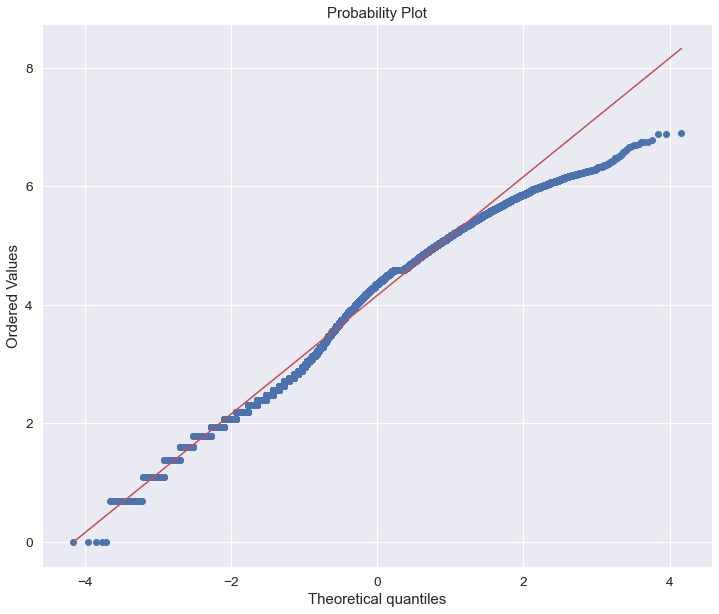

In [108]:
interp_fill_df = interp_fill_df.drop(interp_fill_df[interp_fill_df['pm2.5'] == 0].index).reset_index(drop=True)
interp_fill_df['pm2.5_log'] = np.log(interp_fill_df['pm2.5'])
plt.figure()
stats.probplot(interp_fill_df['pm2.5_log'], plot=plt)

In [109]:
# get the train set and test set
interp_train_df = interp_fill_df[interp_fill_df['denote'] == True]
interp_test_df = interp_fill_df[interp_fill_df['denote'] == False]

x_var = ['DEWP','TEMP','PRES','Iws','Is','Ir','NE','NW','SE','cv']
X_train, X_test = interp_train_df[x_var], interp_test_df[x_var]
y_train, y_test = interp_train_df['pm2.5_log'], interp_test_df['pm2.5_log']

In [110]:
lr_interp = LinearRegression().fit(X_train, y_train)
y_pred_lr_interp = lr_interp.predict(X_test)
r2_lr_interp = lr_interp.score(X_test, y_test)
mse_lr_interp = mean_squared_error(y_true=y_test, y_pred=y_pred_lr_interp)

#### 3、使用kNN模型填充缺失值

In [111]:
from sklearn.impute import KNNImputer

((array([-4.16136993, -3.95421209, -3.84121651, ...,  3.84121651,
          3.95421209,  4.16136993]),
  array([  1.,   1.,   1., ..., 972., 980., 994.])),
 (82.1352576852744, 98.61771517677454, 0.9140332784970606))

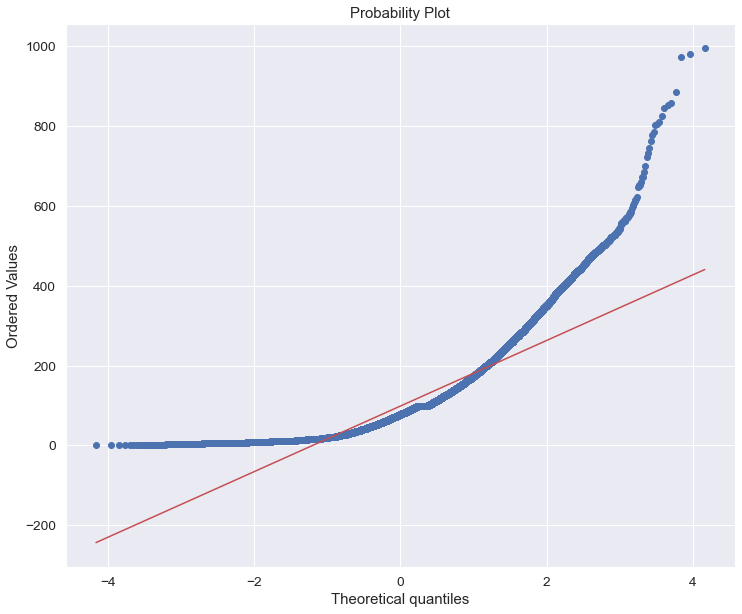

In [112]:
imputer = KNNImputer(n_neighbors=4)
knn_fill_df = PRSA_df
knn_fill_df['pm2.5'] = imputer.fit_transform(PRSA_df[['pm2.5']])

plt.figure()
stats.probplot(interp_fill_df['pm2.5'], plot=plt)

In [113]:
knn_fill_df[knn_fill_df['pm2.5'] == 0]

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,...,NW,SE,cv,date,time_period,day_of_week,week_time,holiday,season,denote
24034,24035,2012,9,28,10,0.0,-5,20.0,1020.0,NW,...,1,0,0,2012-09-28 10:00:00,1,5,1,1,3,True
24039,24040,2012,9,28,15,0.0,-10,24.0,1017.0,NW,...,1,0,0,2012-09-28 15:00:00,2,5,1,1,3,True


((array([-4.16136993, -3.95421209, -3.84121651, ...,  3.84121651,
          3.95421209,  4.16136993]),
  array([0.        , 0.        , 0.        , ..., 6.8793558 , 6.88755257,
         6.90173721])),
 (1.0016016272607524, 4.157266233266752, 0.9881246526764511))

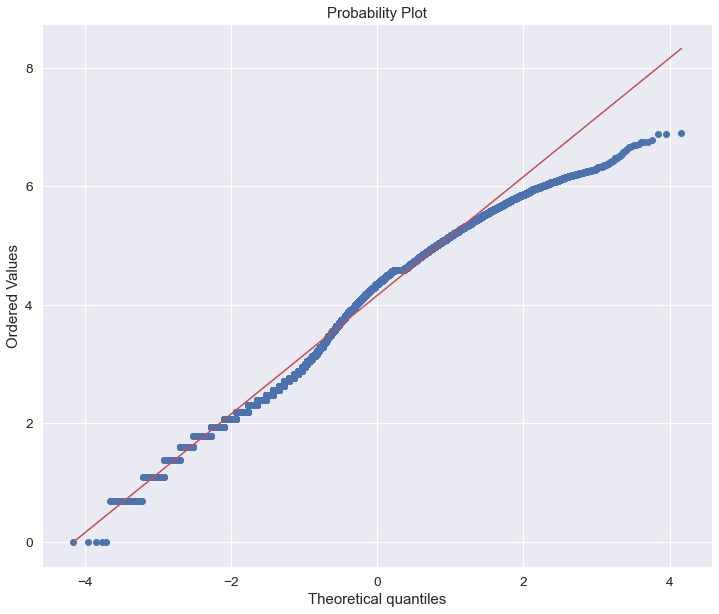

In [114]:
knn_fill_df = knn_fill_df.drop(knn_fill_df[knn_fill_df['pm2.5'] == 0].index).reset_index(drop=True)
knn_fill_df['pm2.5_log'] = np.log(knn_fill_df['pm2.5'])
plt.figure()
stats.probplot(knn_fill_df['pm2.5_log'], plot=plt)

In [115]:
# get the train set and test set
knn_train_df = knn_fill_df[knn_fill_df['denote'] == True]
knn_test_df = knn_fill_df[knn_fill_df['denote'] == False]

x_var = ['DEWP','TEMP','PRES','Iws','Is','Ir','NE','NW','SE','cv']
X_train, X_test = knn_train_df[x_var], knn_test_df[x_var]
y_train, y_test = knn_train_df['pm2.5_log'], knn_test_df['pm2.5_log']

In [116]:
lr_knn = LinearRegression().fit(X_train, y_train)
y_pred_lr_knn = lr_knn.predict(X_test)
r2_lr_knn = lr_knn.score(X_test, y_test)
mse_lr_knn = mean_squared_error(y_true=y_test, y_pred=y_pred_lr_knn)

#### 4、删除法、均值填补、插值填补、kNN填补的比较

显然，在这个数据集中，效果几乎一样。但是在这里，删除法仍然是最优的方法。

R^2 score: (nan, mean, interp, knn)
0.3658681236394825
0.35062503353144536
0.35062503353144536
0.35062503353144536
mean square error: (nan, mean, interp, knn)
0.6894037300941444
0.684335247276805
0.684335247276805
0.684335247276805


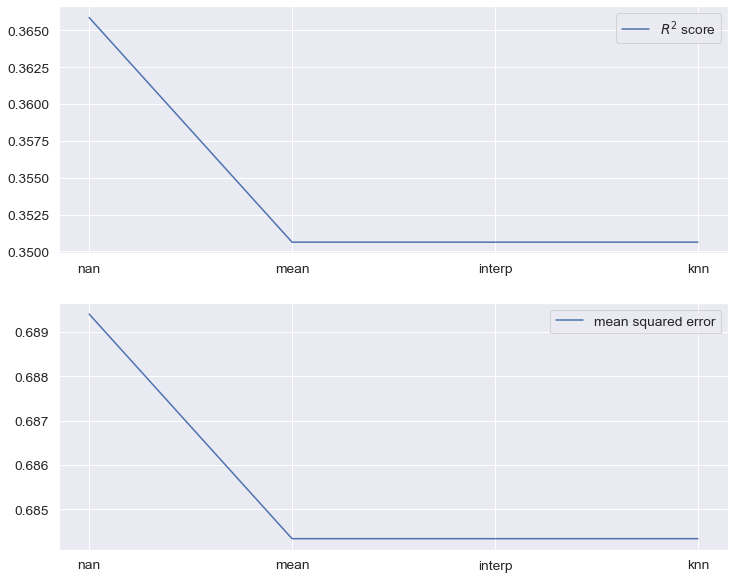

In [118]:
r2_list = [r2_lr_nan, r2_lr_mean, r2_lr_interp, r2_lr_knn]
mse_list = [mse_lr_nan, mse_lr_mean, mse_lr_interp, mse_lr_knn]

print('R^2 score: (nan, mean, interp, knn)')
for r2 in r2_list:
    print(r2)

print('mean square error: (nan, mean, interp, knn)')
for mse in mse_list:
    print(mse)

fig, ax = plt.subplots(2)
ax[0].plot(['nan', 'mean', 'interp', 'knn'], r2_list, label='$R^2$ score')
ax[0].legend(loc='best')
ax[1].plot(['nan', 'mean', 'interp', 'knn'], mse_list, label='mean squared error')
ax[1].legend(loc='best')

### 四、pm2.5分级，分类预测

In [119]:
def grade(x):
    if x <= 35:
        return 1               # 'low'
    elif x <= 150:
        return 2               # 'mid'
    elif x > 150:
        return 3               # 'high'
# grade on pm2.5
no_nan_df['grade'] = no_nan_df['pm2.5'].apply(grade)

# smooth time series: 3-hour window
cols = no_nan_df.shape[1]
cnt = 0
mean = 0
while cnt <= cols-3:
    mean = (no_nan_df['TEMP'].iloc[cnt] + no_nan_df['TEMP'].iloc[cnt+1] + no_nan_df['TEMP'].iloc[cnt+2]) / 3
    no_nan_df['TEMP'].iloc[cnt] = mean
    no_nan_df['TEMP'].iloc[cnt+1] = mean 
    no_nan_df['TEMP'].iloc[cnt+2] = mean
    cnt += 3

d:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


可以看出，中级PM状态的数据占大多数。

       pm2.5
grade       
1      12118
2      20646
3       8991


<AxesSubplot:ylabel='pm2.5'>

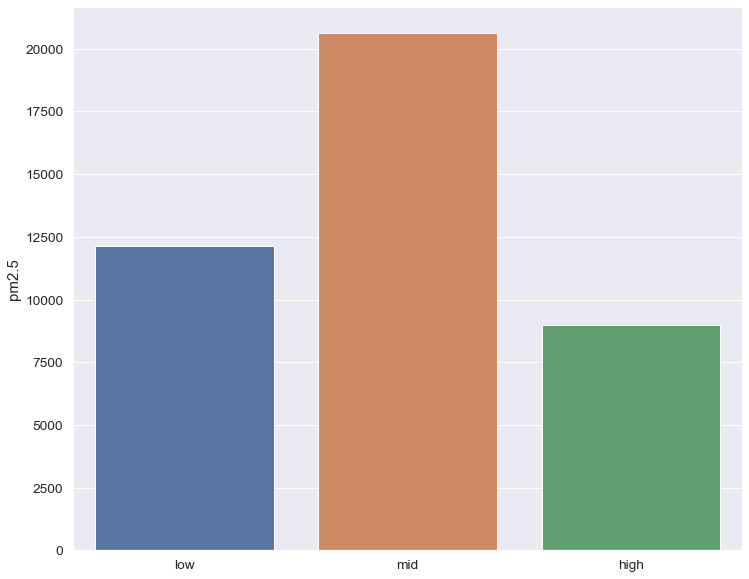

In [120]:
data = no_nan_df[['pm2.5','grade']].groupby(['grade']).count()
print(data)
sns.barplot(x=['low','mid','high'],y=data['pm2.5'])

使用分类器对未来的PM状态等级做预测

提取训练集和测试集

In [121]:
# get the train set and test set
train_df = no_nan_df[no_nan_df['denote'] == True]
test_df = no_nan_df[no_nan_df['denote'] == False]

x_var = ['DEWP','TEMP','PRES','Iws','Is','Ir','NE','NW','SE','cv']
X_train, X_test = train_df[x_var], test_df[x_var]
y_train, y_test = train_df['grade'], test_df['grade']

In [122]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

cv交叉验证取最佳参数

In [123]:
knn = KNeighborsClassifier(n_neighbors=3)
param_dict = {
    'n_neighbors':range(1,5),
    'metric':['hamming','minkowski','jaccard']
}
estimator = GridSearchCV(estimator=knn,param_grid=param_dict,cv=5)
estimator.fit(X=X_train, y=y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'metric': ['hamming', 'minkowski', 'jaccard'],
                         'n_neighbors': range(1, 5)})

In [124]:
# print(estimator.cv_results_) # 获取交叉验证结果
print(estimator.best_params_) # 得到最好的metric和n_neighbors
print(estimator.best_score_) # 最好的R^2

{'metric': 'minkowski', 'n_neighbors': 4}
0.558307792790243


图中红线是预测值，蓝线是验证值。由图可以看出预测的效果还是可以的。

In [30]:
knn_best = KNeighborsClassifier(n_neighbors=4, metric='minkowski')
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)
r2 = knn_best.score(X_test, y_test)
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
print('R^2 score: {}'.format(r2))
print('mean squared error: {}'.format(mse))

R^2 score: 0.6334661354581673
mean squared error: 0.43824701195219123


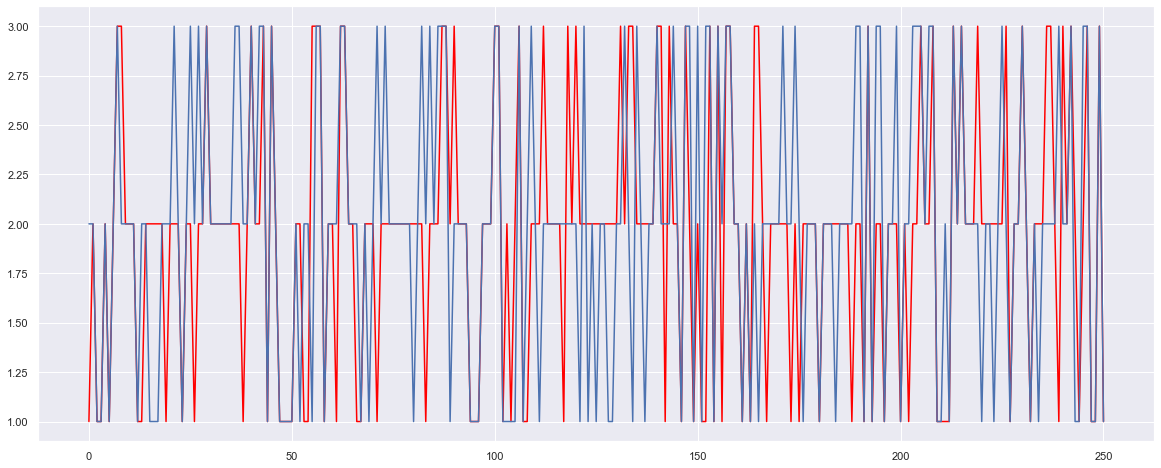

In [31]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_pred)), y_pred, c='red')
plt.plot(np.arange(len(y_test)), y_test)
plt.show()

## 五、总结

在本次project中，我初次尝试从头到尾自我实现了一次回归预测pm2.5的变化，分类预测pm2.5的等级。了解到了选取不同特征对预测的影响，而且尝试发掘了隐藏于不同特征的组合中的新特征。虽然最终结果可能比不上大多数人，但是对于数据科学的认识仍然更进了一层。